<a href="https://colab.research.google.com/github/gracelcai/career-launch-group-13/blob/main/exercise_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import PyTorch and other libraries

In [1]:
import torch
import numpy as np

# 1. Download and process Kaggle data
We are using the Kaggle dataset of landmarks, distances, and angles of 5 different exercise.

For the dataset and more info, see: https://www.kaggle.com/competitions/fitness-pose-classification/discussion

In [2]:
!pip install -q opendatasets

In [3]:
# upload kaggle json file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/muhannadtuameh/exercise-recognition/data') # insert ypu kaggle  username and key

distances_data = pd.read_csv('/content/exercise-recognition/3d_distances.csv')
angles_data = pd.read_csv('/content/exercise-recognition/angles.csv')
landmarks_data = pd.read_csv('/content/exercise-recognition/landmarks.csv')
xyz_distances_data = pd.read_csv('/content/exercise-recognition/xyz_distances.csv')

labels_data = pd.read_csv('/content/exercise-recognition/labels.csv')['pose'].tolist()

100%|██████████| 1.07M/1.07M [00:00<00:00, 41.4MB/s]

In [5]:
distances_data.shape

(1372, 17)

In [6]:
landmarks_data.head()

,pose_id,x_nose,y_nose,z_nose,x_left_eye_inner,y_left_eye_inner,z_left_eye_inner,x_left_eye,y_left_eye,z_left_eye,...,z_left_heel,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index
0,0,-5.889507,-57.637520,-45.019750,-4.656085,-62.832863,-44.571823,-3.302626,-63.386856,-44.567863,...,56.852562,-0.842025,35.037060,50.565020,5.842190,45.971020,50.263714,0.092779,45.842150,41.427795
1,1,-4.255504,-62.935925,-128.907500,-2.977403,-67.035990,-124.258545,-2.215265,-67.198250,-124.263240,...,-14.129170,-1.298891,54.733307,-6.886051,3.980098,65.370830,-49.023930,-5.090634,65.641780,-42.878056
2,2,-2.878917,-61.709988,-137.453340,-1.619050,-65.693750,-132.181660,-0.785822,-65.814340,-132.184070,...,-19.904400,-2.119770,51.265694,-15.554097,1.994894,62.725025,-57.717957,-4.452602,62.494457,-53.804527
3,3,-4.242575,-60.371220,-135.094830,-3.118133,-64.416000,-129.995930,-2.369744,-64.603290,-130.003400,...,-6.855729,-1.485475,59.729427,1.433403,1.950102,68.187256,-42.989098,-4.573338,68.144350,-34.117043
4,4,-0.805543,-56.178570,-41.124413,-0.055174,-58.501305,-37.938560,0.456936,-58.473960,-37.954430,...,47.124107,-2.455719,52.861732,45.936783,2.699764,57.254112,27.531416,-2.288348,57.803005,26.288315


In [7]:
# turn string labels into class numbers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
class_names = ["jumping_jacks_down", "jumping_jacks_up",
               "pullups_down", "pullups_up",
               "pushups_down", "pushups_up",
               "situp_down", "situp_up",
               "squats_down", "squats_up"]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_data)
labels

array([0, 0, 0, ..., 9, 9, 9])

In [8]:
# turn all data into tensors
distances = torch.from_numpy(distances_data.to_numpy()[:, 1:]).type(torch.float)
xyz_distances = torch.from_numpy(xyz_distances_data.to_numpy()[:, 1:]).type(torch.float)
angles = torch.from_numpy(angles_data.to_numpy()[:, 1:]).type(torch.float)
landmarks = torch.from_numpy(landmarks_data.to_numpy()[:, 1:]).type(torch.float)

In [9]:
# combine data
X = torch.cat(tensors=[distances, xyz_distances, angles, landmarks],
                dim=1)
# X = landmarks
# turn labels into tensor
y = torch.from_numpy(labels).type(torch.float)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([1372, 170])
y shape: torch.Size([1372])


In [10]:
# display first 5 entries
import pandas as pd
frames = [distances_data, xyz_distances_data, angles_data, landmarks_data]
result = pd.concat(frames)

result.head()

,pose_id,left_shoulder_left_wrist,right_shoulder_right_wrist,left_hip_left_ankle,right_hip_right_ankle,left_hip_left_wrist,right_hip_right_wrist,left_shoulder_left_ankle,right_shoulder_right_ankle,left_hip_right_wrist,...,z_left_heel,x_right_heel,y_right_heel,z_right_heel,x_left_foot_index,y_left_foot_index,z_left_foot_index,x_right_foot_index,y_right_foot_index,z_right_foot_index
0,0,38.423300,39.855762,62.640720,57.871964,15.052525,20.688140,107.80279,101.256220,25.964552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,65.631510,65.847110,55.631300,53.715553,106.099660,99.581940,108.05316,108.368080,99.120370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,69.661674,69.360990,55.770256,53.510430,110.819440,109.959590,103.96043,102.363594,109.834720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,52.437600,55.870330,57.758915,57.445232,97.575290,94.503000,119.82603,118.113594,92.485230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,30.867628,43.872227,67.210240,65.753365,25.952522,44.106445,105.16242,102.763930,44.958740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # percentage of test
                                                    # shuffle=True,
                                                    random_state=42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([1097, 170]), X_test shape: torch.Size([275, 170])
y_train shape: torch.Size([1097]), y_test shape: torch.Size([275])


# 2. Create the Model

In [13]:
import torch
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
class ExerciseModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

exercise_model_0 = ExerciseModelV0(input_features=X.size(dim=1),
                                   hidden_units=200,
                                   output_features=10).to(device)
exercise_model_0

ExerciseModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=170, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=10, bias=True)
  )
)

# 3. Train the model

## 3.1 Functions and Setup

In [15]:
# set model version
model = exercise_model_0

In [16]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [17]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

## 3.2 Training

In [18]:
# fit the multi-class model to the data
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

epochs = 1050

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor))
    test_acc = accuracy_fn(y_true=y_test,
                      y_pred=test_pred)

    if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 7.49102, Accuracy: 8.11% | Test loss: 22.31142, Test accuracy: 15.64%
Epoch: 50 | Loss: 0.49967, Accuracy: 83.77% | Test loss: 0.68600, Test accuracy: 74.18%
Epoch: 100 | Loss: 0.37211, Accuracy: 87.69% | Test loss: 0.61429, Test accuracy: 77.45%
Epoch: 150 | Loss: 0.28810, Accuracy: 90.79% | Test loss: 0.59548, Test accuracy: 78.55%
Epoch: 200 | Loss: 0.22873, Accuracy: 93.53% | Test loss: 0.56172, Test accuracy: 78.55%
Epoch: 250 | Loss: 0.23369, Accuracy: 91.80% | Test loss: 0.57886, Test accuracy: 77.45%
Epoch: 300 | Loss: 0.16745, Accuracy: 95.35% | Test loss: 0.53593, Test accuracy: 81.82%
Epoch: 350 | Loss: 0.15513, Accuracy: 95.99% | Test loss: 0.55168, Test accuracy: 78.55%
Epoch: 400 | Loss: 0.12795, Accuracy: 96.35% | Test loss: 0.52093, Test accuracy: 80.73%
Epoch: 450 | Loss: 0.10481, Accuracy: 97.27% | Test loss: 0.51067, Test accuracy: 82.91%
Epoch: 500 | Loss: 0.09681, Accuracy: 97.45% | Test loss: 0.51388, Test accuracy: 83.27%
Epoch: 550 | Loss: 0.094

# 4. Evaluate the model

1. Make predictions with trained model on test dataset
2. Make a confusion matrix with `torchmetrics.ConfusionMatrix`
3. Plot the confusion using `mlxtend.plotting.plot_confusion_matrix()`
torchmetrics: https://torchmetrics.readthedocs.io/en/v0.10.2/classification/confusion_matrix.html

In [19]:
from tqdm.auto import tqdm

# 1. make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  y_logit = model(X)
  y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

  print(y_pred)

tensor([0, 0, 0,  ..., 9, 9, 9])


In [20]:
# import libraries for model evaluation
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 19 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.0 MB/s eta 0:00:00
mlxtend version: 0.23.1


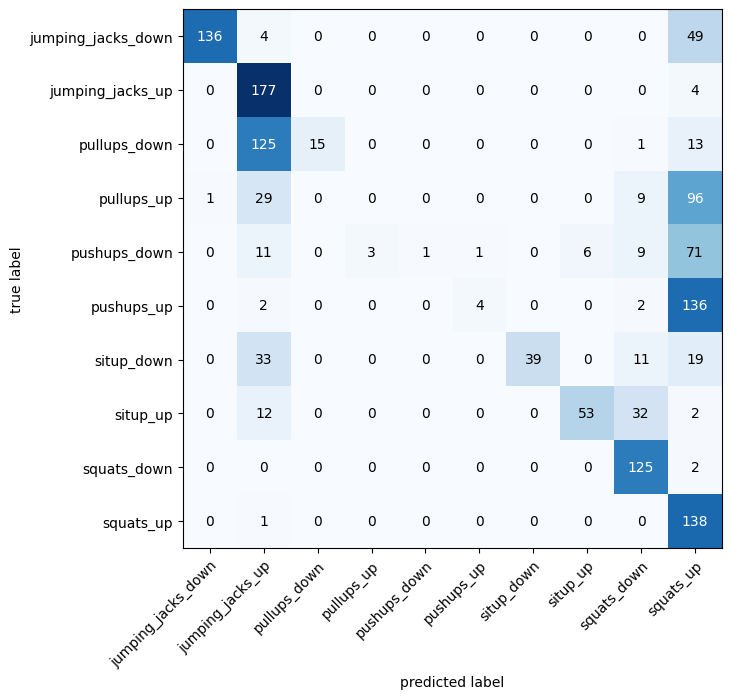

In [21]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred,
                         target=y)

# 3. plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# 5. Save the model

In [22]:
# saving a model
from pathlib import Path
# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "classificationModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/classificationModel.pth


In [23]:
# loading a model in PyTorch
# since we saved our model's 'state_dict()' (just the parameters) rather then the entire model, we'll create a new instance of our model class and load the saved 'state_dict()' into that

# instantiate a new instance
loaded_model = LinearRegressionModel()

# load saved state_dict of model_0
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

NameError: name 'LinearRegressionModel' is not defined

In [ ]:
# make predictions with loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)